# Rubric 

|평가문항	|상세기준| 내 평가|
|--|--|--|
|1. 시계열 데이터를 정상 데이터로 만드는 과정에서 주요한 시각화 과정을 확인하였는가?|학습 단계별 결과가 제대로 출력되었으며 </br>로그 변환, 계절성 제거, 특성 중요도 시각화를 통해 적용이 잘 되었는지 확인하였다.|Done|
|2. 시계열 데이터를 분석하는 통계적 지표와 분류 모델의 성능을 확인하는 지표를 확인하였는가?|정상성을 확인하는 지표에서 ADF와 P-value를 확인하고</br>Classification report를 확인해보았다.|Done|
|3. 시계열 분류 모델 3가지가 성공적으로 작동하는가?|Logistic Regression, RandomForest, XGBoost의 </br>모델 학습 및 테스트가 정상적으로 수행되고, 결과값을 얻었다.|Done|

- 미니프로젝트의 목표!
    - Objective 1 : 비정상 데이터를 정상 데이터로 만들어봅시다!
    - Objective 2: 강의에 활용되었던 분류 모델의 성능을 높여봅시다!

- 아래의 순서대로 코드 실습이 진행됩니다. 코드를 실행하는 부분이 어떤 순서에 해당하는지 천천히 확인해보세요.

            ① 비정상 데이터를 정상 데이터로 만들기  
            ② 분산을 일정하게 만들기 - log transformation  
            ③ 차분을 통해 추세 제거하기  
            ④ (추가) 계절 차분을 통해 계절성 제거하기  
            ⑤ 검정을 통해 정상성 확인하기  
            ⑥ 시계열 분류  
                    ⑥-1 : 데이터 다운로드 및 불러오기  
                    ⑥-2 : 데이터셋 확인(timeseries와 y 확인)  
                    ⑥-3 : 데이터셋 가공   
                    ⑥-4 : 데이터셋 나누기  
                    ⑥-5 : Feature extraction   
                    ⑥-6 : impute  
                    ⑥-7 : RandomForest 및 XGBoost 사용 및 score 확인  
                    ⑥-8 : XGBoost plot_importance 확인 및 시각화  
                    ⑥-9 : Classification report를 통한 검증 및 분석  

</br>
- 1-5와 6의 데이터를 다른 걸 사용하네 ...

# Preliminary Work

- Install tsfresh 

In [1]:
# !pip install tsfresh

In [2]:
# # 라이브러리 버전 충돌을 피하기 위해 런타임을 재시작합니다.
# import os
# os.kill(os.getpid(), 9)

- Import library

In [3]:
# 라이브러리를 불러옵니다.
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

- import data

# Air Passengers

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
path = '/content/drive/MyDrive/Colab Notebooks/aiffel/Time_series(7주차)/'
ap = pd.read_csv(path+'AirPassengers.csv')
ap



,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


### delete 'Month'

In [6]:
# month 열 지우기 
ap = ap.drop('Month', axis=1) #구지 'Month'를 지우지 않고 인텍스를 지우고 학습까지 해도 될 것을...
ap

,#Passengers
0,112
1,118
2,132
3,129
4,121
...,...
139,606
140,508
141,461
142,390


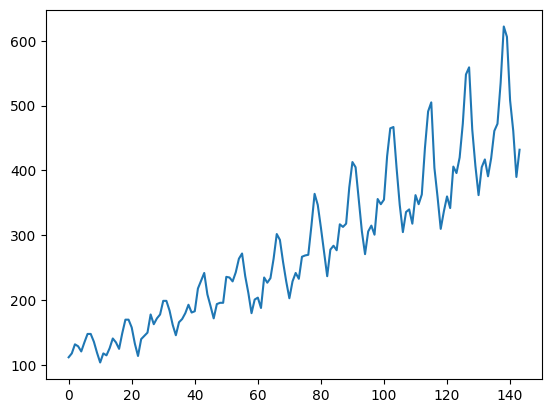

In [7]:
# 데이터 확인 
plt.figure()
plt.plot(ap)
plt.show()
#그래프를 보면 점점 값이 증가함 => 추세가 있음
#그래프를 중심으로 위 아래 선을 가로 방향으로 선을 그을 수 있느데 이것이 오른쪽으로 갈 수록 넓어짐 => 분산이 커지고 있음.  

### log transformation
- 점점 넓어지는 분산을 보정

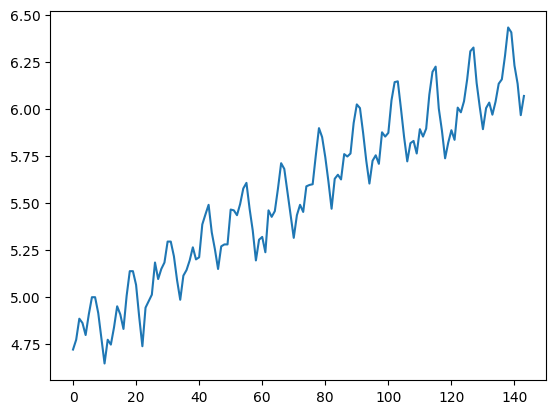

In [8]:
# np.log를 통해서 log transformation 분산이 점점 넓어지는 것을 보정
log_transformed = np.log(ap)
plt.figure()
plt.plot(log_transformed)
plt.show()

In [9]:
log_transformed

,#Passengers
0,4.718499
1,4.770685
2,4.882802
3,4.859812
4,4.795791
...,...
139,6.406880
140,6.230481
141,6.133398
142,5.966147


### differencing
- 점점 증가하는 추세를 없애줌 

In [10]:
# diff() 함수를 통해 간단하게 차분을 수행할 수 있습니다.
diffed = log_transformed.diff()[1:]  # 0 행이 null이 되기 때문에 diff 한 다음에 0 행 이후 값만 diffed에 넣는다. 
diffed
# 차분을 하면 데이터의 수가 적어진다. 데이터를 잘라서 쓰거나 없어진 데이터가 null이 들어가 있는 것을 꼭 지워준다.
# 차분은 보통 1번 많으면 2번 대체적으로 3번이상 하지 않는다. 
# 옆 데이터와 빼주는 건 마치 미분 같은 느낌.

,#Passengers
1,0.052186
2,0.112117
3,-0.022990
4,-0.064022
5,0.109484
...,...
139,-0.026060
140,-0.176399
141,-0.097083
142,-0.167251


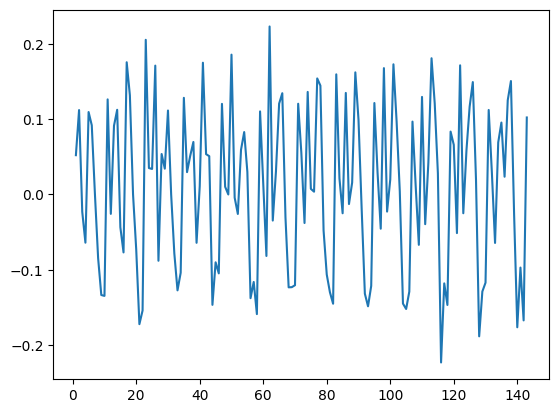

In [11]:
# 커지는 분산과 증가하는 추세를 제거한 air passengers 데이터를 얻을 수 있습니다.
plt.figure()
plt.plot(diffed)
plt.show()
# 추세와 분산의 변화를 없애주니 노이즈 같은 느낌의 그래프가 나옴. residual이나  white noise라 부름.
# 나중에 seasonal_decompose를 사용하여  이 작업을 

### seasonal differencing
- 계절성 제거 

In [12]:
# diff에 12라는 값을 넣어주면 주기를 12로 하는 계절 차분을 수행할 수 있습니다.
seasonally_diffed = diffed.diff(12)
# 차분을 하면 데이터가 짧아지기 때문에 빈칸을 제거해야 합니다.
seasonally_diffed.dropna(inplace = True)

In [13]:
# 아래 데이터는 dropna를 적용하기 전의 데이터입니다. 먼저 형태를 확인해봅시다.
seasonally_diffed  #앞에 12개가 지워지는 거군 그럼 diff(12)[13:]이렇게 뒤에 넣어주어도 되었겠네 

,#Passengers
13,0.039164
14,0.000361
15,-0.020496
16,-0.012939
17,0.066148
...,...
139,-0.045934
140,0.012024
141,0.031830
142,-0.050082


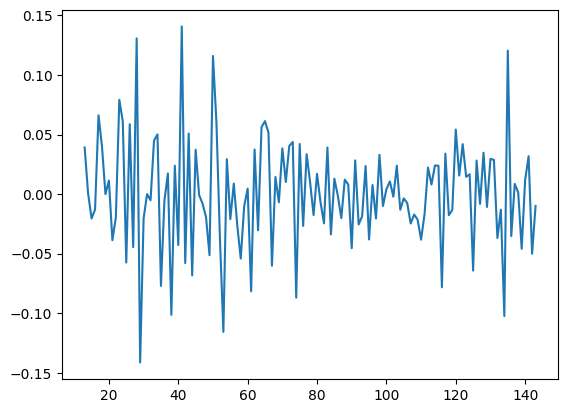

In [14]:
# 아래와 같은 데이터를 얻을 수 있습니다.
plt.figure()
plt.plot(seasonally_diffed)
plt.show() #육안으로 보기에 더 안정적이게 보이지는 않음.

### test
- ADF

In [15]:
from statsmodels.tsa.stattools import adfuller

def adf_test(x): # adf검정을 위한 함수 정의
    stat, p_value, lags, nobs, crit, icb = adfuller(x) # adfuller 함수를 이용하면 6가지 output이 나옵니다.
    print('ADF statistics')
    print(stat) # ADF 검정 통계량입니다.
    print('P-value')
    print(p_value) # P-value입니다.

In [16]:
# 계절차분까지 수행한 데이터로 adf 테스트를 수행합니다.
adf_test(seasonally_diffed)
# P-value가 0.0002이므로 유의수준 0.01에서 단위근이 존재한다는 가설을 기각하고 이 시계열은 정상성이 있다라는 대립가설을 채택할 수 있다. 

ADF statistics
-4.4433249418311425
P-value
0.00024859123113838495


# Robot execution 

##1 Import Data from tsfresh
- robot_execution이라는 것이 무엇일까? 아무것도 모르지만 분석할 수 있다. 
- sample 데이터라 모르고도 좋은 성능을 낼 수 있겠지만 실제로는 도메인 지식을 미리 학습을 해야 함. 

In [17]:
# ⑥-1 : 데이터 다운로드 및 불러오기
from tsfresh.examples.robot_execution_failures import download_robot_execution_failures, load_robot_execution_failures

# robot exection failures 데이터를 불러옵니다.
download_robot_execution_failures()
timeseries, y = load_robot_execution_failures()

In [18]:
# ⑥-2 : 데이터셋 확인(timeseries와 y 확인)
timeseries # id, time을 제외하고 6개 column의 X변수가 나타납니다.

,id,time,F_x,F_y,F_z,T_x,T_y,T_z
0,1,0,-1,-1,63,-3,-1,0
1,1,1,0,0,62,-3,-1,0
2,1,2,-1,-1,61,-3,0,0
3,1,3,-1,-1,63,-2,-1,0
4,1,4,-1,-1,63,-3,-1,0
...,...,...,...,...,...,...,...,...
1315,88,10,-10,2,39,-21,-24,5
1316,88,11,-11,2,38,-24,-22,6
1317,88,12,-12,3,23,-24,-24,5
1318,88,13,-13,4,26,-29,-27,5


In [19]:
y # true/false가 제시되어 있습니다. 
# 이진 분류

1      True
2      True
3      True
4      True
5      True
      ...  
84    False
85    False
86    False
87    False
88    False
Length: 88, dtype: bool

## Extra work (Simple EDA)
https://medium.com/@janhesse53/robot-execution-failures-c0c4bd2c3361  
어떤 데이터인가?  
- For each instance there were 15 time intervals evenly spaced over 315 ms immediately after failure detection   
    - 이래서 시계열?
    - 15번 * 88개 ID(아마도 88개 로봇) = 1320 데이터  
- F : Force , T : Torque
- ID 1은 성공.. 
    - 그래프에서 확인하라는 데 force나 torque의 기준 값이 있어 벗어나면 실패라고 하는 듯
    - 20을 보면 그래프가 출렁이는 데 이것은 실패
    - 로봇 실험 데이터는 성공이 중요할까 실패가 중요할까? ㅋㅋ 뭔말이야?
    - 샘플 데이터는 레퍼런스로 팁을 얻는데 생전 모르는 데이터는 이렇게 알아내는 것이 시간이 많이 걸리겠음 ㅜㅜ 
- 아무튼 이런 데이터랍니다. 

In [57]:
def plot_sensor_data(id):
    
    df = timeseries[timeseries['id'] == id]
    sensor_cols = df.columns[2:]
    
    fig, axes = plt.subplots(2,3, figsize=(16,6))
    axes = axes.flatten()
    
    for ax, col in zip(range(len(axes)),sensor_cols):
        col_mean = df[col][1:].mean()
        axes[ax].plot(df['time'].values,df[col].values)
        axes[ax].set_title(col)
        axes[ax].set_ylim([col_mean-30,col_mean+30])

True

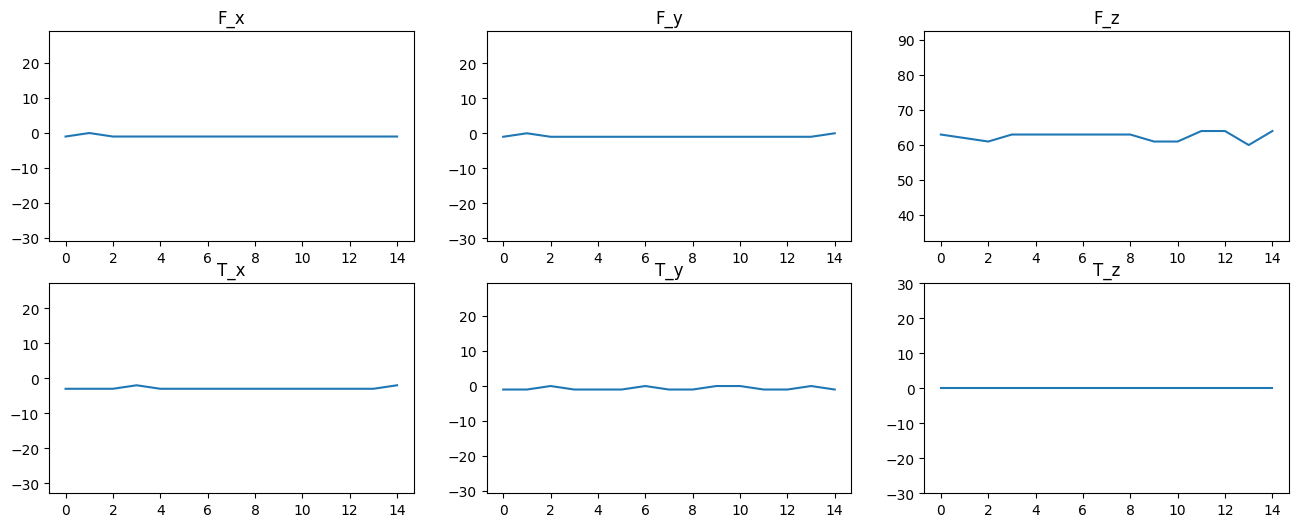

In [65]:
plot_sensor_data(1)
y[1]

False

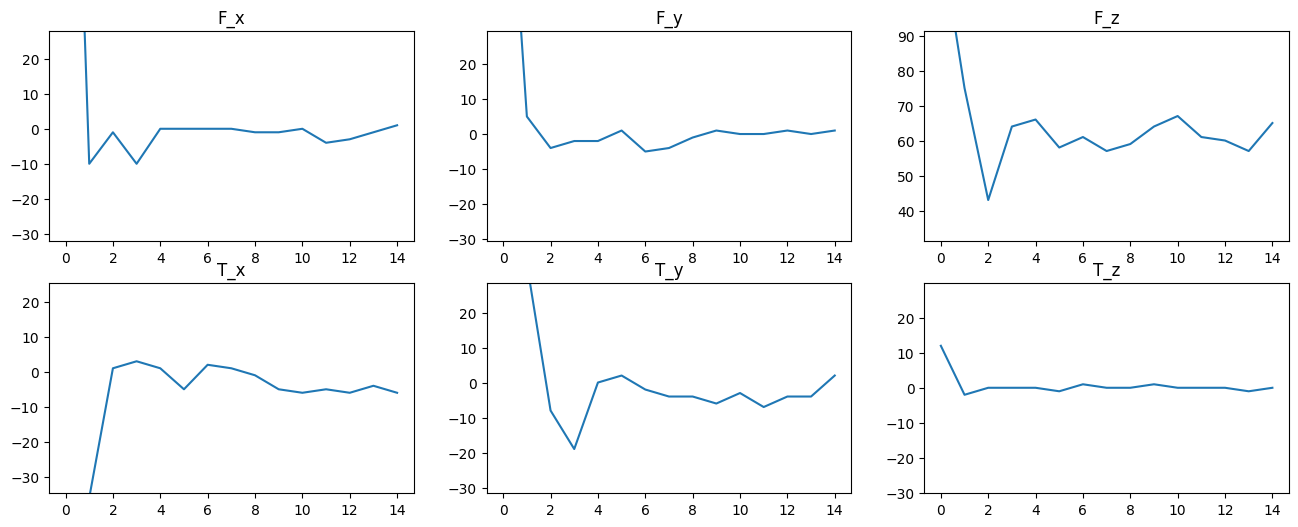

In [64]:
plot_sensor_data(20)
y[20]

##2 Split data

In [20]:
# ⑥-3 : 데이터셋 가공
def custom_classification_split(x,y,test_size=0.3): # 수업 때 보았던 custom split 함수 ID와 time을 통해 분류하기 때문에에 이런 메아리치는 한글 입력 어떻게 고치냠.
    
    num_true = int(y.sum()*test_size)
    num_false = int((len(y)-y.sum())*test_size)  #0.3만큼 test로 분리 
    
    id_list = y[y==False].head(num_false).index.to_list() + y[y==True].head(num_true).index.to_list() #id_list 추출
    
    y_train = y.drop(id_list)
    y_test = y.iloc[id_list].sort_index()
    X_train = timeseries[~timeseries['id'].isin(id_list)]
    X_test = timeseries[timeseries['id'].isin(id_list)]     #id_list를 바탕으로 train, test를 분리
    
    return X_train, y_train, X_test, y_test    

In [21]:
# ⑥-4 : 데이터셋 나누기
# test set의 비율을 0.25로 지정해주세요.
X_train, y_train, X_test, y_test = custom_classification_split(timeseries, y, test_size = 0.25)

##3 Extract features
- 시계열의 데이터 바로 사용하는 거보다 특징들을 추출하여 input으로 사용하면 좀 더 설명 가능하며 높은 성능의 모델을 만들어 낼 수 있다. 

In [22]:
from tsfresh import extract_features
from tsfresh.feature_extraction import EfficientFCParameters    #모든 파라미터를 사용하기 위해 comprehensiveFC를 사용해야 하지만 속도가 느려서...
from tsfresh.utilities.dataframe_functions import impute  #간단하게 데이터의 null을 정리해줌.

settings = EfficientFCParameters()

In [23]:
# ⑥-5 : Feature extraction
comprehensive_features_train = extract_features(
                                    X_train, 
                                    column_id="id",   
                                    column_sort="time",     #id, time 고정
                                    default_fc_parameters=settings    # 파라미터 세팅
                                          )

Feature Extraction: 100%|██████████| 402/402 [00:28<00:00, 14.03it/s]


In [24]:
comprehensive_features_test = extract_features(
                                    X_test, 
                                    column_id="id",
                                    column_sort="time",
                                    default_fc_parameters=settings
                                          )

Feature Extraction: 100%|██████████| 126/126 [00:05<00:00, 21.01it/s]


In [25]:
# ⑥-6 : impute
impute(comprehensive_features_train)   #결측값을 없앴다. 

/usr/local/lib/python3.9/dist-packages/tsfresh/utilities/dataframe_functions.py:198: RuntimeWarning: The columns ['F_x__partial_autocorrelation__lag_7'
 'F_x__partial_autocorrelation__lag_8'
 'F_x__partial_autocorrelation__lag_9' ...
 'T_z__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"'
 'T_z__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"'
 'T_z__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


,F_x__variance_larger_than_standard_deviation,F_x__has_duplicate_max,F_x__has_duplicate_min,F_x__has_duplicate,F_x__sum_values,F_x__abs_energy,F_x__mean_abs_change,F_x__mean_change,F_x__mean_second_derivative_central,F_x__median,...,T_z__fourier_entropy__bins_5,T_z__fourier_entropy__bins_10,T_z__fourier_entropy__bins_100,T_z__permutation_entropy__dimension_3__tau_1,T_z__permutation_entropy__dimension_4__tau_1,T_z__permutation_entropy__dimension_5__tau_1,T_z__permutation_entropy__dimension_6__tau_1,T_z__permutation_entropy__dimension_7__tau_1,T_z__query_similarity_count__query_None__threshold_0.0,T_z__mean_n_absolute_max__number_of_maxima_7
6,1.0,1.0,1.0,1.0,-15.0,39.0,1.714286,0.142857,0.153846,-1.0,...,0.974315,1.213008,1.732868,1.438883,1.863680,2.145842,2.163956,2.197225,0.0,0.714286
7,0.0,1.0,0.0,1.0,-13.0,21.0,0.928571,0.214286,-0.076923,-1.0,...,1.255482,1.494175,2.079442,1.043794,1.349792,1.666333,1.748067,1.831020,0.0,0.428571
8,1.0,0.0,1.0,1.0,-10.0,26.0,1.142857,-0.142857,0.192308,-1.0,...,1.494175,1.732868,2.079442,1.412745,2.138333,2.397895,2.302585,2.197225,0.0,1.285714
9,1.0,0.0,0.0,1.0,-10.0,24.0,1.428571,0.000000,-0.076923,-1.0,...,1.255482,1.494175,2.079442,1.479133,2.138333,2.397895,2.302585,2.197225,0.0,1.285714
10,0.0,0.0,1.0,1.0,-14.0,14.0,0.142857,0.000000,0.000000,-1.0,...,0.937285,1.213008,1.906155,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,1.0,1.0,0.0,1.0,-1073.0,96833.0,7.142857,-5.428571,-0.038462,-98.0,...,0.735622,0.735622,1.386294,1.585771,2.253858,2.397895,2.302585,2.197225,0.0,24.285714
85,1.0,0.0,1.0,1.0,143.0,1683.0,1.357143,1.071429,0.076923,8.0,...,0.735622,0.735622,1.667462,1.332245,1.589027,1.893788,2.163956,2.197225,0.0,5.571429
86,1.0,0.0,0.0,0.0,961.0,83497.0,9.071429,9.071429,0.807692,52.0,...,0.735622,1.073543,1.732868,0.687092,0.983088,1.159589,1.227529,1.303092,0.0,9.285714
87,1.0,1.0,0.0,1.0,4509.0,1405437.0,12.928571,12.214286,-1.038462,338.0,...,0.735622,0.735622,1.386294,0.535961,0.836988,1.159589,1.497866,1.581094,0.0,40.285714


In [26]:
impute(comprehensive_features_test)

/usr/local/lib/python3.9/dist-packages/tsfresh/utilities/dataframe_functions.py:198: RuntimeWarning: The columns ['F_x__partial_autocorrelation__lag_7'
 'F_x__partial_autocorrelation__lag_8'
 'F_x__partial_autocorrelation__lag_9' ...
 'T_z__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"'
 'T_z__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"'
 'T_z__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


,F_x__variance_larger_than_standard_deviation,F_x__has_duplicate_max,F_x__has_duplicate_min,F_x__has_duplicate,F_x__sum_values,F_x__abs_energy,F_x__mean_abs_change,F_x__mean_change,F_x__mean_second_derivative_central,F_x__median,...,T_z__fourier_entropy__bins_5,T_z__fourier_entropy__bins_10,T_z__fourier_entropy__bins_100,T_z__permutation_entropy__dimension_3__tau_1,T_z__permutation_entropy__dimension_4__tau_1,T_z__permutation_entropy__dimension_5__tau_1,T_z__permutation_entropy__dimension_6__tau_1,T_z__permutation_entropy__dimension_7__tau_1,T_z__query_similarity_count__query_None__threshold_0.0,T_z__mean_n_absolute_max__number_of_maxima_7
1,0.0,0.0,1.0,1.0,-14.0,14.0,0.142857,0.000000,-0.038462,-1.0,...,1.073543,1.440235,2.079442,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.0,0.000000
2,0.0,1.0,1.0,1.0,-13.0,25.0,1.000000,0.000000,-0.038462,-1.0,...,1.073543,1.494175,2.079442,0.937156,1.234268,1.540306,1.748067,1.831020,0.0,0.571429
3,0.0,0.0,1.0,1.0,-10.0,12.0,0.714286,0.000000,-0.038462,-1.0,...,1.386294,1.732868,2.079442,1.265857,1.704551,2.019815,2.163956,2.197225,0.0,0.571429
4,0.0,1.0,1.0,1.0,-6.0,16.0,1.214286,-0.071429,-0.038462,0.0,...,1.073543,1.494175,2.079442,1.156988,1.907284,2.397895,2.302585,2.197225,0.0,1.000000
5,0.0,0.0,0.0,1.0,-9.0,17.0,0.928571,-0.071429,0.038462,-1.0,...,0.900256,1.320888,2.079442,1.156988,1.863680,2.271869,2.302585,2.197225,0.0,0.857143
19,1.0,0.0,0.0,1.0,99.0,6109.0,13.928571,-1.928571,-1.730769,1.0,...,0.974315,1.494175,1.906155,1.230932,1.704551,2.019815,2.025326,2.043192,0.0,1.428571
20,1.0,0.0,1.0,1.0,155.0,34455.0,16.714286,-13.142857,7.576923,-1.0,...,1.386294,1.667462,2.079442,1.564957,2.022809,2.271869,2.302585,2.197225,0.0,2.571429
21,1.0,0.0,0.0,1.0,-171.0,16495.0,20.928571,1.785714,3.961538,-1.0,...,0.735622,0.735622,0.735622,1.303876,1.791759,2.271869,2.302585,2.197225,0.0,17.285714
22,1.0,0.0,0.0,1.0,102.0,12700.0,10.785714,-8.071429,4.500000,-1.0,...,0.562335,0.735622,1.732868,1.524707,2.138333,2.397895,2.302585,2.197225,0.0,5.428571
23,1.0,0.0,0.0,1.0,67.0,10593.0,15.142857,-7.000000,3.000000,-3.0,...,0.974315,1.255482,2.079442,1.519383,2.369382,2.397895,2.302585,2.197225,0.0,3.714286


##4 Machine learning

- 평가 지표에 대한 정리  

|평가지표|의미|오차행렬과의 관계|
|------|---|---|
|accuracy|얼마나 정확하고 </br>잘못 예측한 결과가 없었는지 평가|(TP+TN)/(TP+TN+FN+FP)|
|recall|실제 참 데이터 중 예측 참|TP/(TP+FN)|
|precision|예측 참 중 실제 참, 예측 참에 집중|TP/(TP+FP)|
|f1|recall&precision의 조화평균, </br>1에 가까울수록 좋음. |2/(recall^-1+precision^-1)|
|support|각 라벨의 실제 샘플 수|

###4-1 RandomForestClassifier

In [44]:
# ⑥-7 : RandomForest 사용 및 score 확인
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators = 10, max_depth = 3)

rf_clf.fit(comprehensive_features_train, y_train)

RandomForestClassifier(max_depth=3, n_estimators=10)

In [45]:
# test셋에 적합해본 결과 약 0.66의 정확도를 보이며 불만족스러운 결과를 확인할 수 있습니다. 
rf_clf.score(comprehensive_features_test, y_test)
# 다른데? 실행할 떄마다 다른 값이 나옴.

0.9047619047619048

In [29]:
import pprint # json이나 dictionary 같은 거 정돈되게 프린트하고 싶을 때.. 근데 줄도 맞췄으면 좋겠네..

In [50]:
from sklearn.metrics import classification_report

print(classification_report(y_test, rf_clf.predict(comprehensive_features_test), target_names = ['true', 'false'])) 
#노드에서는 print안쓰고 dictionary 타입으로 출력을 했는데 값 보기 힘들어 바꿨다. 왜 그렇게 어지럽게 값을 확인했을까?

              precision    recall  f1-score   support

        true       1.00      0.88      0.93        16
       false       0.71      1.00      0.83         5

    accuracy                           0.90        21
   macro avg       0.86      0.94      0.88        21
weighted avg       0.93      0.90      0.91        21



- 각 성공 실패의 데이터 수가 불균형함. 이때는 f1을 보라했음. 0.91(각 가중치를 염두하고 계산한 weighted) 정도 생각하면 되겠음. 
- 0.91 정도면 괜찮은데....

In [56]:
classification_report(y_test, rf_clf.predict(comprehensive_features_test), target_names = ['true', 'false'], output_dict = True)

{'true': {'precision': 1.0,
  'recall': 0.875,
  'f1-score': 0.9333333333333333,
  'support': 16},
 'false': {'precision': 0.7142857142857143,
  'recall': 1.0,
  'f1-score': 0.8333333333333333,
  'support': 5},
 'accuracy': 0.9047619047619048,
 'macro avg': {'precision': 0.8571428571428572,
  'recall': 0.9375,
  'f1-score': 0.8833333333333333,
  'support': 21},
 'weighted avg': {'precision': 0.9319727891156463,
  'recall': 0.9047619047619048,
  'f1-score': 0.9095238095238096,
  'support': 21}}

###4-2 XGBoosClassifier

In [32]:
# ⑥-7 : XGBoost 사용 및 score 확인
import xgboost as xgb
xgb_clf = xgb.XGBClassifier(n_estimators = 10, max_depth = 3)

# XGBoost 모델을 학습시킵니다.
xgb_clf.fit(comprehensive_features_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [33]:
# XGBoost 모델의 score를 확인합니다.
xgb_clf.score(comprehensive_features_test, y_test)

1.0

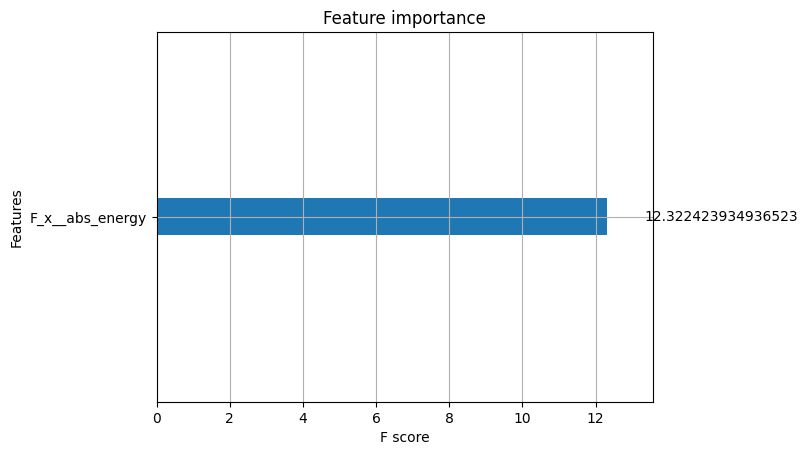

In [36]:
# ⑥-8 : XGBoost plot_importance 확인 및 시각화
# plot_importance를 통해 어떤 변수(특징)가 가장 유의미한지 확인합니다. 어떤 x가 큰 역할을 했는지
xgb.plot_importance(xgb_clf, importance_type = 'gain')
plt.show()

In [34]:
sum(xgb_clf.feature_importances_ != 0) # Fx 값의 abs_energy 특징만이 유의미함
# F_x_abs_energy = 값 제곱들의 합합

1

In [52]:
# ⑥-9 : Classification report를 통한 검증 및 분석
from sklearn.metrics import classification_report

print(classification_report(y_test, xgb_clf.predict(comprehensive_features_test), target_names = ['true', 'false'])) 

              precision    recall  f1-score   support

        true       1.00      1.00      1.00        16
       false       1.00      1.00      1.00         5

    accuracy                           1.00        21
   macro avg       1.00      1.00      1.00        21
weighted avg       1.00      1.00      1.00        21



XGBoost는 모든 값이 완벽했다. 

###4-3 LogisticRegressionClassifier

In [37]:
# ⑥-7 : LogisticRegression 사용 및 score 확인
from sklearn.linear_model import LogisticRegression
LR_clf = LogisticRegression(random_state = 0)

# LogisticRegression 모델을 학습시킵니다.
LR_clf.fit(comprehensive_features_train, y_train)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=0)

In [38]:
# LogisticRegression 모델의 score를 확인합니다.
LR_clf.score(comprehensive_features_test, y_test)

0.5714285714285714

In [54]:
# ⑥-9 : Classification report를 통한 검증 및 분석
from sklearn.metrics import classification_report

print(classification_report(y_test, LR_clf.predict(comprehensive_features_test), target_names = ['true', 'false']))

              precision    recall  f1-score   support

        true       1.00      0.44      0.61        16
       false       0.36      1.00      0.53         5

    accuracy                           0.57        21
   macro avg       0.68      0.72      0.57        21
weighted avg       0.85      0.57      0.59        21



0.59 이 모델은 못쓰겠네...